In [1]:
import geemap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from IPython.display import display
import ee
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from IPython.display import display
import os
import seaborn as sns
import statsmodels.formula.api as sm
from numpy.polynomial.polynomial import polyfit
from sklearn.model_selection import train_test_split
import sklearn
from math import sqrt
import glob

In [2]:
ee.Initialize()

Map = geemap.Map(center=[40,-100], zoom=4)

##Adding every plot coordinate - GA and VA
allplots_ga = 'C:/Users/arj26323/Documents/Data/Biomass datasets/Sapelo/GA_allplots_NEW.csv'
fc_ga = geemap.csv_to_ee(allplots_ga, latitude = "Latitude", longitude = "Longitude")

allplots_va= pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Virginia/Coordinates and biomass/va_allpoints.csv')
allplots_va = allplots_va[allplots_va['liveMass'].notna()]
allplots_va = allplots_va[allplots_va['Latitude'].notna()]
allplots_va = allplots_va.drop(columns = ['deadMass', 'collectDate', 'totalMass', 'Ell', 'MSL', 'latitude', 'longitude'])

##Group va df and average (midpoint) the replicates (a/b)
df_temp=allplots_va.copy()

df_temp = df_temp.groupby(['Year','locationID','Transect','Latitude','Longitude'],as_index = False).aggregate(
    {
        'liveMass':[np.mean, np.size]
    }
)

df_temp.columns = [
    'Year','locationID','Transect','Latitude','Longitude','liveMass','N'
]

allplots_va = df_temp

fc_va = geemap.pandas_to_ee(allplots_va, latitude = "Latitude", longitude = "Longitude")

Map.addLayer(fc_ga, {}, "fc_ga")
Map.addLayer(fc_va, {}, "fc_va")

In [3]:
##Data masking steps

##Function to cloud mask from the pixel_qa band of Landsat 5/8 SR data.
def maskL5sr(image):
  ## Bits 3 and 5 are cloud shadow and cloud, respectively.
  cloudShadowBitMask = 1 << 3
  cloudsBitMask = 1 << 5

  ##Get the pixel QA band.
  qa = image.select('pixel_qa')

  ##Both flags should be set to zero, indicating clear conditions.
  mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0) \
      .And(qa.bitwiseAnd(cloudsBitMask).eq(0))

  ##Return the masked image, scaled to reflectance, without the QA bands.
  return image.updateMask(mask).divide(10000) \
      .select("B[0-9]*") \
      .copyProperties(image, ["system:time_start"])

##TIDAL FILTERING

def addFLATS(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(-1.57 + 20*(RED-SWIR)/(RED+SWIR) + 68.6*(GREEN-RED)/(GREEN+RED)))', {
            'SWIR': image.select('B6'),
            'RED': image.select('B4'),
            'GREEN': image.select('B3')
        })
    
    return image.addBands(flats.rename('flats'))

##Notes: This is setup for Landsat 8 - apply to l5?

def addFLATSL5(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(-1.57 + 20*(RED-SWIR)/(RED+SWIR) + 68.6*(GREEN-RED)/(GREEN+RED)))', {
            'SWIR': image.select('B5'),
            'RED': image.select('B3'),
            'GREEN': image.select('B2')
        })
    
    return image.addBands(flats.rename('flats'))

##MASKING FLATS
def maskFLATS(image):
    mask1 = image.select('flats').lte(0.1) #less than or equal to 0.1 - change?
    return image.updateMask(mask1)

In [4]:
##Adding DEM
dem = ee.Image('USGS/3DEP/10m') ##This is 1/3 arc second, or 10 m.
dem1 = ee.ImageCollection('USGS/3DEP/1m')

##Set visualization parameters.
dem_params = {
    'min': 0,
    'max': 4000,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5'],
}

Map.addLayer(dem, dem_params, '10m DEM')
Map.addLayer(dem1, dem_params, '1m DEM')

dem = dem.select(['elevation'], ['Elevation'])

In [16]:
##Virginia
vdfu = pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Virginia/Streamlined/va_mayoct.csv')
vdfv = pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Virginia/Streamlined/va_yr.csv')
vdfx = pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Virginia/Streamlined/va_augoct.csv')
vdfy = pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Virginia/Streamlined/va_sepoct.csv')
vmin = pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Virginia/Streamlined/va_min.csv')
vmax = pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Virginia/Streamlined/va_max.csv')

vmin.rename(
    columns={
        'ndvi':'ndvi_min'
    }, inplace=True
)

vmax.rename(
    columns={
        'ndvi':'ndvi_max'
    }, inplace=True
)

vdfu.rename(
    columns={
        'ndvi':'ndvi_mayoct','savi':'savi_mayoct','wdrvi5':'wdrvi5_mayoct','nd_r_g':'nd_r_g_mayoct', 'nd_g_b':'nd_g_b_mayoct',
        'nd_swir2_nir':'nd_swir2_nir_mayoct', 'nd_swir2_r':'nd_swir2_r_mayoct'
    }, inplace=True
)

vdfv.rename(
    columns={
        'ndvi':'ndvi_yr','savi':'savi_yr','wdrvi5':'wdrvi5_yr','nd_r_g':'nd_r_g_yr', 'nd_g_b':'nd_g_b_yr',
        'nd_swir2_nir':'nd_swir2_nir_yr', 'nd_swir2_r':'nd_swir2_r_yr'
    }, inplace=True
)

vdfx.rename(
    columns={
        'ndvi':'ndvi_augoct','savi':'savi_augoct','wdrvi5':'wdrvi5_augoct','nd_r_g':'nd_r_g_augoct', 'nd_g_b':'nd_g_b_augoct',
        'nd_swir2_nir':'nd_swir2_nir_augoct', 'nd_swir2_r':'nd_swir2_r_augoct'
    }, inplace=True
)

vdfy.rename(
    columns={
        'ndvi':'ndvi_sepoct','savi':'savi_sepoct','wdrvi5':'wdrvi5_sepoct','nd_r_g':'nd_r_g_sepoct', 'nd_g_b':'nd_g_b_sepoct',
        'nd_swir2_nir':'nd_swir2_nir_sepoct', 'nd_swir2_r':'nd_swir2_r_sepoct'
    }, inplace=True
)

vminmax = pd.merge(vmin, vmax, left_index=True, right_index=True,
             how='outer', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')

vdf0 = pd.merge(vdfv, vdfx, left_index=True, right_index=True,
             how='outer', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')

vdf0x = pd.merge(vdfu, vdf0, left_index=True, right_index=True,
             how='outer', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')

vdf = pd.merge(vminmax, vdf0x, left_index=True, right_index=True,
             how='outer', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')

vdf1 = pd.merge(vdf, vdfy, left_index=True, right_index=True,
             how='outer', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')

vdf1['ident'] = vdf1['ndvi_yr'] * vdf1['ndvi_augoct'] * vdf1['ndvi_sepoct'] * vdf1['ndvi_mayoct']

vdf1['LTER'] = 'VA'
vdf1.rename(columns={'elevation':'Elevation'}, inplace=True)

display(vdf1)

##Georgia
gdfu = pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Sapelo/Streamlined/df_mayoct.csv')
gdfv = pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Sapelo/Streamlined/df_yr.csv')
gdfw = pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Sapelo/Streamlined/df_octnov.csv')
gdfx = pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Sapelo/Streamlined/df_augoct.csv')
gdfy = pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Sapelo/Streamlined/df_sepoct.csv')
gdfz = pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Sapelo/Streamlined/df_oct.csv')
gmin = pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Sapelo/Streamlined/df_min.csv')
gmax = pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Sapelo/Streamlined/df_max.csv')

gmin.rename(
    columns={
        'ndvi':'ndvi_min'
    }, inplace=True
)

gmax.rename(
    columns={
        'ndvi':'ndvi_max'
    }, inplace=True
)

gdfu.rename(
    columns={
        'ndvi':'ndvi_mayoct','savi':'savi_mayoct','wdrvi5':'wdrvi5_mayoct','nd_r_g':'nd_r_g_mayoct', 'nd_g_b':'nd_g_b_mayoct',
        'nd_swir2_nir':'nd_swir2_nir_mayoct', 'nd_swir2_r':'nd_swir2_r_mayoct'
    }, inplace=True
)

gdfv.rename(
    columns={
        'ndvi':'ndvi_yr','savi':'savi_yr','wdrvi5':'wdrvi5_yr','nd_r_g':'nd_r_g_yr', 'nd_g_b':'nd_g_b_yr',
        'nd_swir2_nir':'nd_swir2_nir_yr', 'nd_swir2_r':'nd_swir2_r_yr'
    }, inplace=True
)

gdfw.rename(
    columns={
        'ndvi':'ndvi_octnov','savi':'savi_octnov','wdrvi5':'wdrvi5_octnov','nd_r_g':'nd_r_g_octnov', 'nd_g_b':'nd_g_b_octnov',
        'nd_swir2_nir':'nd_swir2_nir_octnov', 'nd_swir2_r':'nd_swir2_r_octnov'
    }, inplace=True
)

gdfx.rename(
    columns={
        'ndvi':'ndvi_augoct','savi':'savi_augoct','wdrvi5':'wdrvi5_augoct','nd_r_g':'nd_r_g_augoct', 'nd_g_b':'nd_g_b_augoct',
        'nd_swir2_nir':'nd_swir2_nir_augoct', 'nd_swir2_r':'nd_swir2_r_augoct'
    }, inplace=True
)

gdfy.rename(
    columns={
        'ndvi':'ndvi_sepoct','savi':'savi_sepoct','wdrvi5':'wdrvi5_sepoct','nd_r_g':'nd_r_g_sepoct', 'nd_g_b':'nd_g_b_sepoct',
        'nd_swir2_nir':'nd_swir2_nir_sepoct', 'nd_swir2_r':'nd_swir2_r_sepoct'
    }, inplace=True
)

gminmax = pd.merge(gmin, gmax, left_index=True, right_index=True,
             how='outer', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')

gdf0 = pd.merge(gdfv, gdfx, left_index=True, right_index=True,
             how='outer', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')

gdf0x = pd.merge(gdfu, gdf0, left_index=True, right_index=True,
             how='outer', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')

gdf = pd.merge(gminmax, gdf0x, left_index=True, right_index=True,
             how='outer', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')

gdf1 = pd.merge(gdfy, gdf, left_index=True, right_index=True,
             how='outer', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')

gdf1['LTER'] = 'GA'

gdf1['ident'] = gdf1['ndvi_yr'] * gdf1['ndvi_augoct'] * gdf1['ndvi_sepoct'] * gdf1['ndvi_mayoct']

gdf1.rename(columns={'Plant_Biomass':'liveMass'}, inplace=True)
gdf1.rename(columns={'elevation':'Elevation'}, inplace=True)

gdf1 = gdf1[gdf1['Species_Code'] == 'A1'] ##Critical step

#Combining the datasets

df1 = pd.concat([gdf1, vdf1])

df1 = df1[df1['ident'].notna()] ##remove rows with NaN for columns used in the model 

display(df1)

,Year,locationID,Latitude,liveMass,Longitude,Transect,N,ndvi_min,Elevation,swe,...,nd_swir2_r_augoct,ndvi_sepoct,savi_sepoct,wdrvi5_sepoct,nd_r_g_sepoct,nd_g_b_sepoct,nd_swir2_nir_sepoct,nd_swir2_r_sepoct,ident,LTER
0,1999,1,37.167147,46.72,-75.940768,A,2,0.228605,0.157865,0.019534,...,-0.066493,0.250916,0.067466,-0.089940,-0.020359,0.132979,-0.312200,-0.066493,0.003454,VA
1,1999,1,37.174764,399.68,-75.942417,A,2,0.306192,0.170457,0.019534,...,-0.009877,0.306192,0.087636,-0.030227,0.036755,0.151515,-0.315115,-0.009877,0.008129,VA
2,1999,1,37.180976,441.68,-75.940766,A,2,0.322975,0.417727,0.019945,...,-0.003375,0.414314,0.145102,0.093956,-0.029380,0.183980,-0.417105,-0.003375,0.020663,VA
3,1999,1,37.287699,669.60,-75.929487,A,2,0.467063,0.601948,0.428658,...,0.176107,0.618321,0.273957,0.358974,-0.017199,0.269939,-0.496251,0.176107,0.095936,VA
4,1999,1,37.345970,875.52,-75.901065,A,2,0.297033,0.476658,0.374959,...,0.108817,0.424025,0.178325,0.105620,0.035055,0.163515,-0.330456,0.108817,0.020403,VA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003,2017,3,37.287875,96.08,-75.929008,B,2,0.678704,1.035588,0.610603,...,0.252567,0.686454,0.372871,0.457896,-0.044039,0.186089,-0.488264,0.298107,0.229953,VA
1004,2017,3,37.167768,26.56,-75.944280,C,2,0.414301,0.627959,0.893397,...,0.194727,0.422785,0.215164,0.104126,0.051064,0.134860,-0.216045,0.227521,0.038301,VA
1005,2017,3,37.449973,279.36,-75.671952,C,1,0.654660,1.261021,0.618466,...,0.234450,0.663949,0.349052,0.424582,-0.077966,0.155104,-0.508682,0.234450,0.173638,VA
1006,2018,1,37.396051,255.04,-75.876056,C,1,0.534464,0.957294,0.047479,...,0.220411,0.551863,0.309689,0.267790,-0.006429,0.155593,-0.377351,0.220411,0.083406,VA


,Site,Species_Code,Year,Zone,Plot,Latitude,liveMass,Sample_Size,Longitude,Date,...,wdrvi5_augoct,nd_r_g_augoct,nd_g_b_augoct,nd_swir2_nir_augoct,nd_swir2_r_augoct,LTER,ident,locationID,Transect,N
0,1.0,A1,2000,1.0,1.0,31.538627,516.324,23.0,-81.422539,10/11/2000,...,0.012609,-0.020024,0.074442,-0.274221,0.077605,GA,0.010324,NaN,NaN,NaN
2,4.0,A1,2000,1.0,1.0,31.451676,1534.304,25.0,-81.365498,10/10/2000,...,-0.042724,0.034398,0.110169,-0.399095,-0.118194,GA,0.007153,NaN,NaN,NaN
3,5.0,A1,2000,1.0,1.0,31.436090,2022.264,25.0,-81.339919,10/10/2000,...,0.137864,-0.059056,0.189841,-0.409557,0.050200,GA,0.035323,NaN,NaN,NaN
4,6.0,A1,2000,1.0,1.0,31.388423,1032.632,20.0,-81.279792,10/12/2000,...,-0.079755,-0.010095,0.080531,-0.405237,-0.161814,GA,0.007236,NaN,NaN,NaN
5,9.0,A1,2000,1.0,1.0,31.352109,1484.164,20.0,-81.333734,10/16/2000,...,0.064135,-0.030818,0.217064,-0.383589,0.006536,GA,0.019486,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003,NaN,NaN,2017,NaN,NaN,37.287875,96.080,NaN,-75.929008,NaN,...,0.484748,-0.083123,0.225420,-0.549450,0.252567,VA,0.229953,3.0,B,2.0
1004,NaN,NaN,2017,NaN,NaN,37.167768,26.560,NaN,-75.944280,NaN,...,0.129681,0.037411,0.147155,-0.272668,0.194727,VA,0.038301,3.0,C,2.0
1005,NaN,NaN,2017,NaN,NaN,37.449973,279.360,NaN,-75.671952,NaN,...,0.424582,-0.077966,0.155104,-0.508682,0.234450,VA,0.173638,3.0,C,1.0
1006,NaN,NaN,2018,NaN,NaN,37.396051,255.040,NaN,-75.876056,NaN,...,0.267790,-0.006429,0.155593,-0.377351,0.220411,VA,0.083406,1.0,C,1.0


Mean Absolute Error: 264.5398086515614
Mean Squared Error: 145842.66638709343
Root Mean Squared Error: 381.89352755328736
The r squared is: 0.39537086624243056
0.39537086624243056
testing r2 is: 0.39537086624243056
training r2 is: 0.9031742786583369
NRMSE is: 0.10969186018985065
MEAN BASELINE:
Mean Absolute Error: 356.15688627513896
Root Mean Squared Error: 491.70559288392764


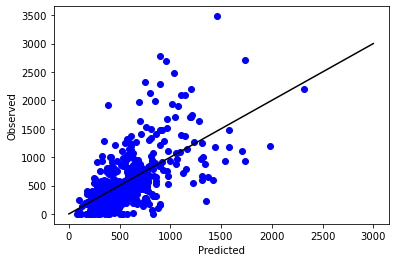

test data correlation coefficient is: 0.6289648952047258
train data correlation coefficient is: 0.9643970724101933


RandomForestRegressor(n_estimators=20, random_state=0)

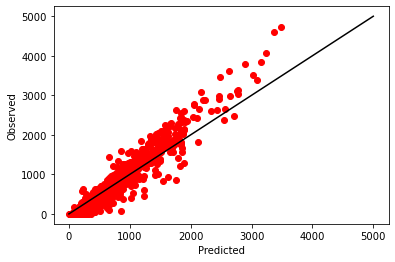

In [75]:
#Combined model
from sklearn.model_selection import train_test_split
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn import metrics

xargs=df1[
    [
        'Elevation', 'tmax', 'tmin', 'ndvi_augoct',
        'savi_augoct','wdrvi5_augoct','nd_r_g_augoct','nd_g_b_augoct','nd_swir2_nir_augoct', 'nd_swir2_r_augoct','ndvi_yr',
        'savi_yr','wdrvi5_yr','nd_r_g_yr','nd_g_b_yr','nd_swir2_nir_yr', 'nd_swir2_r_yr','vp', 'srad', 'prcp'
    ]
]

#, 'ndvi_min', 'ndvi_max'
#removed: 'nd_r_g','dayl','sn_prcp', 'sn_dayl', 'sn_srad', 'sn_vp', 'vp', 'srad', 'prcp'
##DOY!!!

# ##Include lag variables (e.g. lag ndvi), precip, temp, more

yargs=df1['liveMass'] 

size_x = 0.2
seed = 1
xargs_train, xargs_test, yargs_train, yargs_test = train_test_split(xargs, yargs, test_size=size_x, random_state = seed) 
## 80% training and 20% test

# Pipeline example:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
pipe = Pipeline([('scaler', StandardScaler()), ('forest', RandomForestRegressor(n_estimators=100, random_state=seed))])
pipe.fit(xargs_train, yargs_train)
pred=pipe.predict(xargs_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(yargs_test, pred))
print('Mean Squared Error:', metrics.mean_squared_error(yargs_test, pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(yargs_test, pred)))
r_square = metrics.r2_score(yargs_test, pred)
print("The r squared is: " + str(r_square))
print(r_square)
print('testing r2 is: ' + str(pipe.score(xargs_test, yargs_test)))
print('training r2 is: ' + str(pipe.score(xargs_train, yargs_train)))
print('NRMSE is: ' + str(np.sqrt(metrics.mean_squared_error(yargs_test, pred))/np.ptp(yargs_test)))

# Mean
print('MEAN BASELINE:')
pred_mean = [np.mean(yargs_train)] * len(yargs_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(yargs_test, pred_mean))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(yargs_test,pred_mean)))

plt.scatter(pred, yargs_test, color = 'blue') ##label axes - x,y in order?
# plt.plot(X_val, regressor.predict(X_val), color = 'red')
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.plot([0, 3000], [0, 3000], 'k-')
plt.show()

print('test data correlation coefficient is: ' + str(np.corrcoef(yargs_test, pred)[0, 1]))

train_pred = pipe.predict(xargs_train) ##Not sure if this is the right thing to do here
plt.scatter(train_pred, yargs_train, color = 'red')
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.plot([0, 5000], [0, 5000], 'k-')
plt.show

print('train data correlation coefficient is: ' + str(np.corrcoef(train_pred, yargs_train)[0, 1]))

##Can we remove this and use pipeline in the future?
from sklearn.ensemble import RandomForestRegressor
reg_x=RandomForestRegressor(n_estimators=20, random_state = 0) ##Won't let me do 100
# reg_x.fit(xargs_train, yargs_train)
reg_x.fit(xargs, yargs) ##training using all of the data! Splits/k-fold was for model development, not implementation

In [76]:
#Functions

#Yr
def yr_Avg (collection, years):
  avg = []
  for year in years: #Originally had a for month in months subloop, with (month,month,'month') being a filter and set month
      Monthly_avg = collection.filter(ee.Filter.calendarRange(year, year, 'year')) \
                              .filter(ee.Filter.calendarRange(1, 12, 'month')) \
                              .mean() \
                              .set({'year': year})
      avg.append (Monthly_avg)
  return ee.ImageCollection.fromImages(avg)

#Augoct
def augoct_Avg (collection, years):
  avg = []
  for year in years: #Originally had a for month in months subloop, with (month,month,'month') being a filter and set month
      Monthly_avg = collection.filter(ee.Filter.calendarRange(year, year, 'year')) \
                              .filter(ee.Filter.calendarRange(8, 10, 'month')) \
                              .mean() \
                              .set({'year': year})
      avg.append (Monthly_avg)
  return ee.ImageCollection.fromImages(avg)

#Sepoct
def sepoct_Avg (collection, years):
  avg = []
  for year in years: #Originally had a for month in months subloop, with (month,month,'month') being a filter and set month
      Monthly_avg = collection.filter(ee.Filter.calendarRange(year, year, 'year')) \
                              .filter(ee.Filter.calendarRange(9, 10, 'month')) \
                              .mean() \
                              .set({'year': year})
      avg.append (Monthly_avg)
  return ee.ImageCollection.fromImages(avg)


#Daymet
def dm_Avg (collection, years):
  avg = []
  for year in years: #Originally had a for month in months subloop, with (month,month,'month') being a filter
      Monthly_avg = collection.filter(ee.Filter.calendarRange(year, year, 'year')) \
                              .filter(ee.Filter.calendarRange(1, 12, 'month')) \
                              .mean() \
                              .set({'year': year})
      avg.append (Monthly_avg)
  return ee.ImageCollection.fromImages(avg)

In [77]:
#Generating image collections and filtering/masking

years_ls5 = range(2000, 2012)
years_ls7 = range(2012, 2013)
years_ls8 = range(2013, 2021)
years_dm = range(2000, 2021)

months = range(5,11)
months_daymet = range(1,12)

#GA data
ls5_ga = ee.ImageCollection('LANDSAT/LT05/C01/T1_SR').filterBounds(fc_ga).map(maskL5sr).map(addFLATSL5).map(maskFLATS)
ls7_ga = ee.ImageCollection('LANDSAT/LE07/C01/T1_SR').filterBounds(fc_ga).map(maskL5sr).map(addFLATS).map(maskFLATS)
ls8_ga = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR').filterBounds(fc_ga).map(maskL5sr).map(addFLATS).map(maskFLATS)

yr_ga5 = yr_Avg(ls5_ga, years = years_ls5)
yr_gas7 = yr_Avg(ls7_ga, years = years_ls7)
yr_ga8 = yr_Avg(ls8_ga, years = years_ls8)

augoct_ga5 = augoct_Avg(ls5_ga, years = years_ls5)
augoct_ga7 = augoct_Avg(ls7_ga, years = years_ls7)
augoct_ga8 = augoct_Avg(ls8_ga, years = years_ls8)

sepoct_ga5 = sepoct_Avg(ls5_ga, years = years_ls5)
sepoct_ga7 = sepoct_Avg(ls7_ga, years = years_ls7)
sepoct_ga8 = sepoct_Avg(ls8_ga, years = years_ls8)

#VA data
ls5_va = ee.ImageCollection('LANDSAT/LT05/C01/T1_SR').filterBounds(fc_va).map(maskL5sr).map(addFLATSL5).map(maskFLATS)
ls7_va = ee.ImageCollection('LANDSAT/LE07/C01/T1_SR').filterBounds(fc_va).map(maskL5sr).map(addFLATS).map(maskFLATS)
ls8_va = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR').filterBounds(fc_va).map(maskL5sr).map(addFLATS).map(maskFLATS)

yr_va5 = yr_Avg(ls5_va, years = years_ls5)
yr_va7 = yr_Avg(ls7_va, years = years_ls7)
yr_va8 = yr_Avg(ls8_va, years = years_ls8)

augoct_va5 = augoct_Avg(ls5_va, years = years_ls5)
augoct_va7 = augoct_Avg(ls7_va, years = years_ls7)
augoct_va8 = augoct_Avg(ls8_va, years = years_ls8)

sepoct_va5 = sepoct_Avg(ls5_va, years = years_ls5)
sepoct_va7 = sepoct_Avg(ls7_va, years = years_ls7)
sepoct_va8 = sepoct_Avg(ls8_va, years = years_ls8)

#Daymet
daymet_ga = dm_Avg(ee.ImageCollection('NASA/ORNL/DAYMET_V4').filterBounds(fc_ga), years = years_dm)
daymet_va = dm_Avg(ee.ImageCollection('NASA/ORNL/DAYMET_V4').filterBounds(fc_va), years = years_dm)

In [78]:
#Mapping, 2016 - landsat 8

ls8code = 3
dmcode = 16

#GA
ga16_augoct = ee.Image(augoct_ga8.toList(augoct_ga8.size()).get(ls8code)).select(['B1','B2','B3','B4','B5','B6','B7',
                                                                                  'B10','B11'],[
'B1_augoct','B2_augoct','B3_augoct','B4_augoct','B5_augoct','B6_augoct','B7_augoct','B10_augoct','B11_augoct'
])

ga16_sepoct = ee.Image(sepoct_ga8.toList(sepoct_ga8.size()).get(ls8code)).select(['B1','B2','B3','B4','B5','B6','B7',
                                                                                  'B10','B11'],[
    'B1_sepoct','B2_sepoct','B3_sepoct','B4_sepoct','B5_sepoct','B6_sepoct','B7_sepoct','B10_sepoct','B11_sepoct'
])

ga16_yr = ee.Image(yr_ga8.toList(yr_ga8.size()).get(ls8code)).select(['B1','B2','B3','B4','B5','B6','B7',
                                                                      'B10','B11'],[
    'B1_yr','B2_yr','B3_yr','B4_yr','B5_yr','B6_yr','B7_yr','B10_yr','B11_yr'
])

gadm_2016 = ee.Image(daymet_ga.toList(daymet_va.size()).get(dmcode))

#VA
va16_augoct = ee.Image(augoct_va8.toList(augoct_va8.size()).get(ls8code)).select(['B1','B2','B3','B4','B5','B6','B7',
                                                                                  'B10','B11'],[
    'B1_augoct','B2_augoct','B3_augoct','B4_augoct','B5_augoct','B6_augoct','B7_augoct','B10_augoct','B11_augoct'
])

va16_sepoct = ee.Image(sepoct_va8.toList(sepoct_va8.size()).get(ls8code)).select(['B1','B2','B3','B4','B5','B6','B7',
                                                                                  'B10','B11'],[
    'B1_sepoct','B2_sepoct','B3_sepoct','B4_sepoct','B5_sepoct','B6_sepoct','B7_sepoct','B10_sepoct','B11_sepoct'
])

va16_yr = ee.Image(yr_va8.toList(yr_va8.size()).get(ls8code)).select(['B1','B2','B3','B4','B5','B6','B7',
                                                                      'B10','B11'],[
    'B1_yr','B2_yr','B3_yr','B4_yr','B5_yr','B6_yr','B7_yr','B10_yr','B11_yr'
])

vadm_2016 = ee.Image(daymet_va.toList(daymet_va.size()).get(dmcode))

collection_ga16 = ee.ImageCollection([gadm_2016, ga16_augoct,ga16_sepoct,ga16_yr, dem])
collection_va16 = ee.ImageCollection([vadm_2016, va16_augoct,va16_sepoct,va16_yr, dem])

In [79]:
img1_ga = ee.Image([gadm_2016, ga16_augoct,ga16_sepoct,ga16_yr, dem])
img1_va = ee.Image([vadm_2016, va16_augoct,va16_sepoct,va16_yr, dem])

##Adding variables in LANDSAT 8:

#augoct
def addsavi_augoct(image):
    savi_augoct = image.expression(
        '(1.5*(NIR-RED))/(RED+NIR+0.5)', {
            'NIR': image.select('B5_augoct'),
            'RED': image.select('B4_augoct'),
            'GREEN': image.select('B3_augoct')
        })
    
    return image.addBands(savi_augoct.rename('savi_augoct'))

def addwdrvi5_augoct(image):
    wdrvi5_augoct = image.expression(
        '(0.5*NIR-RED)/(RED+NIR*0.5)', {
            'NIR': image.select('B5_augoct'),
            'RED': image.select('B4_augoct'),
            'GREEN': image.select('B3_augoct')
        })
    
    return image.addBands(wdrvi5_augoct.rename('wdrvi5_augoct'))

def addnd_r_g_augoct(image):
    nd_r_g_augoct = image.expression(
        '(RED-GREEN)/(RED+GREEN)', {
            'NIR': image.select('B5_augoct'),
            'RED': image.select('B4_augoct'),
            'GREEN': image.select('B3_augoct')
        })
    
    return image.addBands(nd_r_g_augoct.rename('nd_r_g_augoct'))

def addnd_g_b_augoct(image):
    nd_g_b_augoct = image.expression(
        '(GREEN-BLUE)/(BLUE+GREEN)', {
            'RED': image.select('B4_augoct'),
            'GREEN': image.select('B3_augoct'),
            'BLUE': image.select('B2_augoct')
        })
    
    return image.addBands(nd_g_b_augoct.rename('nd_g_b_augoct'))

def addnd_swir2_nir_augoct(image):
    nd_swir2_nir_augoct = image.expression(
        '(swir2-NIR)/(swir2+NIR)', {
            'NIR': image.select('B5_augoct'),
            'RED': image.select('B4_augoct'),
            'swir2': image.select('B7_augoct')
        })
    
    return image.addBands(nd_swir2_nir_augoct.rename('nd_swir2_nir_augoct'))

def addnd_swir2_r_augoct(image):
    nd_swir2_r_augoct = image.expression(
        '(swir2-RED)/(swir2+RED)', {
            'NIR': image.select('B5_augoct'),
            'RED': image.select('B4_augoct'),
            'swir2': image.select('B7_augoct')
        })
    
    return image.addBands(nd_swir2_r_augoct.rename('nd_swir2_r_augoct'))

def addndvi_augoct(image):
    ndvi_augoct = image.expression(
        '(NIR-RED)/(RED+NIR)', {
            'NIR': image.select('B5_augoct'),
            'RED': image.select('B4_augoct'),
            'GREEN': image.select('B3_augoct')
        })
    
    return image.addBands(ndvi_augoct.rename('ndvi_augoct'))

#sepoct
def addsavi_sepoct(image):
    savi_sepoct = image.expression(
        '(1.5*(NIR-RED))/(RED+NIR+0.5)', {
            'NIR': image.select('B5_sepoct'),
            'RED': image.select('B4_sepoct'),
            'GREEN': image.select('B3_sepoct')
        })
    
    return image.addBands(savi_sepoct.rename('savi_sepoct'))

def addwdrvi5_sepoct(image):
    wdrvi5_sepoct = image.expression(
        '(0.5*NIR-RED)/(RED+NIR*0.5)', {
            'NIR': image.select('B5_sepoct'),
            'RED': image.select('B4_sepoct'),
            'GREEN': image.select('B3_sepoct')
        })
    
    return image.addBands(wdrvi5_sepoct.rename('wdrvi5_sepoct'))

def addnd_r_g_sepoct(image):
    nd_r_g_sepoct = image.expression(
        '(RED-GREEN)/(RED+GREEN)', {
            'NIR': image.select('B5_sepoct'),
            'RED': image.select('B4_sepoct'),
            'GREEN': image.select('B3_sepoct')
        })
    
    return image.addBands(nd_r_g_sepoct.rename('nd_r_g_sepoct'))

def addnd_g_b_sepoct(image):
    nd_g_b_sepoct = image.expression(
        '(GREEN-BLUE)/(BLUE+GREEN)', {
            'RED': image.select('B4_sepoct'),
            'GREEN': image.select('B3_sepoct'),
            'BLUE': image.select('B2_sepoct')
        })
    
    return image.addBands(nd_g_b_sepoct.rename('nd_g_b_sepoct'))

def addnd_swir2_nir_sepoct(image):
    nd_swir2_nir_sepoct = image.expression(
        '(swir2-NIR)/(swir2+NIR)', {
            'NIR': image.select('B5_sepoct'),
            'RED': image.select('B4_sepoct'),
            'swir2': image.select('B7_sepoct')
        })
    
    return image.addBands(nd_swir2_nir_sepoct.rename('nd_swir2_nir_sepoct'))

def addnd_swir2_r_sepoct(image):
    nd_swir2_r_sepoct = image.expression(
        '(swir2-RED)/(swir2+RED)', {
            'NIR': image.select('B5_sepoct'),
            'RED': image.select('B4_sepoct'),
            'swir2': image.select('B7_sepoct')
        })
    
    return image.addBands(nd_swir2_r_sepoct.rename('nd_swir2_r_sepoct'))

def addndvi_sepoct(image):
    ndvi_sepoct = image.expression(
        '(NIR-RED)/(RED+NIR)', {
            'NIR': image.select('B5_sepoct'),
            'RED': image.select('B4_sepoct'),
            'GREEN': image.select('B3_sepoct')
        })
    
    return image.addBands(ndvi_sepoct.rename('ndvi_sepoct'))


#yr
def addsavi_yr(image):
    savi_yr = image.expression(
        '(1.5*(NIR-RED))/(RED+NIR+0.5)', {
            'NIR': image.select('B5_yr'),
            'RED': image.select('B4_yr'),
            'GREEN': image.select('B3_yr')
        })
    
    return image.addBands(savi_yr.rename('savi_yr'))

def addwdrvi5_yr(image):
    wdrvi5_yr = image.expression(
        '(0.5*NIR-RED)/(RED+NIR*0.5)', {
            'NIR': image.select('B5_yr'),
            'RED': image.select('B4_yr'),
            'GREEN': image.select('B3_yr')
        })
    
    return image.addBands(wdrvi5_yr.rename('wdrvi5_yr'))

def addnd_r_g_yr(image):
    nd_r_g_yr = image.expression(
        '(RED-GREEN)/(RED+GREEN)', {
            'NIR': image.select('B5_yr'),
            'RED': image.select('B4_yr'),
            'GREEN': image.select('B3_yr')
        })
    
    return image.addBands(nd_r_g_yr.rename('nd_r_g_yr'))

def addnd_g_b_yr(image):
    nd_g_b_yr = image.expression(
        '(GREEN-BLUE)/(BLUE+GREEN)', {
            'RED': image.select('B4_yr'),
            'GREEN': image.select('B3_yr'),
            'BLUE': image.select('B2_yr')
        })
    
    return image.addBands(nd_g_b_yr.rename('nd_g_b_yr'))

def addnd_swir2_nir_yr(image):
    nd_swir2_nir_yr = image.expression(
        '(swir2-NIR)/(swir2+NIR)', {
            'NIR': image.select('B5_yr'),
            'RED': image.select('B4_yr'),
            'swir2': image.select('B7_yr')
        })
    
    return image.addBands(nd_swir2_nir_yr.rename('nd_swir2_nir_yr'))

def addnd_swir2_r_yr(image):
    nd_swir2_r_yr = image.expression(
        '(swir2-RED)/(swir2+RED)', {
            'NIR': image.select('B5_yr'),
            'RED': image.select('B4_yr'),
            'swir2': image.select('B7_yr')
        })
    
    return image.addBands(nd_swir2_r_yr.rename('nd_swir2_r_yr'))

def addndvi_yr(image):
    ndvi_yr = image.expression(
        '(NIR-RED)/(RED+NIR)', {
            'NIR': image.select('B5_yr'),
            'RED': image.select('B4_yr'),
            'GREEN': image.select('B3_yr')
        })
    
    return image.addBands(ndvi_yr.rename('ndvi_yr'))

In [80]:
##GA
img1_ga = addsavi_augoct(img1_ga)
img1_ga = addwdrvi5_augoct(img1_ga)
img1_ga = addnd_r_g_augoct(img1_ga)
img1_ga = addnd_g_b_augoct(img1_ga)
img1_ga = addnd_swir2_nir_augoct(img1_ga)
img1_ga = addnd_swir2_r_augoct(img1_ga)
img1_ga = addndvi_augoct(img1_ga)

img1_ga = addsavi_sepoct(img1_ga)
img1_ga = addwdrvi5_sepoct(img1_ga)
img1_ga = addnd_r_g_sepoct(img1_ga)
img1_ga = addnd_g_b_sepoct(img1_ga)
img1_ga = addnd_swir2_nir_sepoct(img1_ga)
img1_ga = addnd_swir2_r_sepoct(img1_ga)
img1_ga = addndvi_sepoct(img1_ga)

img1_ga = addsavi_yr(img1_ga)
img1_ga = addwdrvi5_yr(img1_ga)
img1_ga = addnd_r_g_yr(img1_ga)
img1_ga = addnd_g_b_yr(img1_ga)
img1_ga = addnd_swir2_nir_yr(img1_ga)
img1_ga = addnd_swir2_r_yr(img1_ga)
img1_ga = addndvi_yr(img1_ga)

##VA
img1_va = addsavi_augoct(img1_va)
img1_va = addwdrvi5_augoct(img1_va)
img1_va = addnd_r_g_augoct(img1_va)
img1_va = addnd_g_b_augoct(img1_va)
img1_va = addnd_swir2_nir_augoct(img1_va)
img1_va = addnd_swir2_r_augoct(img1_va)
img1_va = addndvi_augoct(img1_va)

img1_va = addsavi_sepoct(img1_va)
img1_va = addwdrvi5_sepoct(img1_va)
img1_va = addnd_r_g_sepoct(img1_va)
img1_va = addnd_g_b_sepoct(img1_va)
img1_va = addnd_swir2_nir_sepoct(img1_va)
img1_va = addnd_swir2_r_sepoct(img1_va)
img1_va = addndvi_sepoct(img1_va)

img1_va = addsavi_yr(img1_va)
img1_va = addwdrvi5_yr(img1_va)
img1_va = addnd_r_g_yr(img1_va)
img1_va = addnd_g_b_yr(img1_va)
img1_va = addnd_swir2_nir_yr(img1_va)
img1_va = addnd_swir2_r_yr(img1_va)
img1_va = addndvi_yr(img1_va)

##Land masking using NLCD:
dataset = ee.ImageCollection('USGS/NLCD_RELEASES/2019_REL/NLCD')
nlcd2019 = dataset.filter(ee.Filter.eq('system:index', '2019')).first() ##use different NLCD image for earlier years
landcover = nlcd2019.select('landcover')
elev_set = dem.select('Elevation')
elevmask = elev_set.updateMask(elev_set.lte(2)) ##Elevation masking - BE CAREFUL HERE!

landcovermask = landcover.remap([31,95], [1,1])

##GA
img1_ga = img1_ga.updateMask(landcovermask)
img1_ga = img1_ga.updateMask(elevmask)

##VA
img1_va = img1_va.updateMask(landcovermask)

Map.addLayer(img1_ga, {}, 'img1_ga')
# Map.addLayer(img1_va, {}, 'img1_va')

feature_names = [
        'Elevation', 'tmax', 'tmin', 'ndvi_augoct',
        'savi_augoct','wdrvi5_augoct','nd_r_g_augoct','nd_g_b_augoct','nd_swir2_nir_augoct', 'nd_swir2_r_augoct','ndvi_yr',
        'savi_yr','wdrvi5_yr','nd_r_g_yr','nd_g_b_yr','nd_swir2_nir_yr', 'nd_swir2_r_yr','vp', 'srad', 'prcp'
]

Map

Map(bottom=1800.0, center=[43.32967314784175, -128.56463531949626], controls=(WidgetControl(options=['position…

In [82]:
##Incorporating ML model into geemap (takes some time)
from geemap import ml

##Model implementation - can we get 'pipe' in here??
trees = ml.rf_to_strings(reg_x, feature_names, output_mode="REGRESSION")

# print(trees[0])
n_trees = 20 ##Very low! Needs to be 100, but gee won't let me use this data. Maybe contact them toward the end? Or reduce data
len(trees) == n_trees

# create a ee classifier to use with ee objects from the trees
ee_classifier = ml.strings_to_classifier(trees)

##VA
classified_va = img1_va.select(feature_names).classify(ee_classifier)

##GA
classified_ga = img1_ga.select(feature_names).classify(ee_classifier)

# classified = img1.select(feature_names).classify(pipe)

In [83]:
import geemap.colormaps as cm
roi2_ga = ee.Geometry.Point([-81.2890, 31.3985]).buffer(300)
roi2_va = ee.Geometry.Point([-75.876094, 37.395746]).buffer(300)
palette = cm.palettes.BuGn

Map.addLayer(
    classified_ga.clip(roi2_ga),
    {"min": 0, "max": 1500, 'palette': palette},
    'classification_ga',
)

Map.addLayer(
    classified_va.clip(roi2_va),
    {"min": 0, "max": 1500, 'palette': palette},
    'classification_va',
)


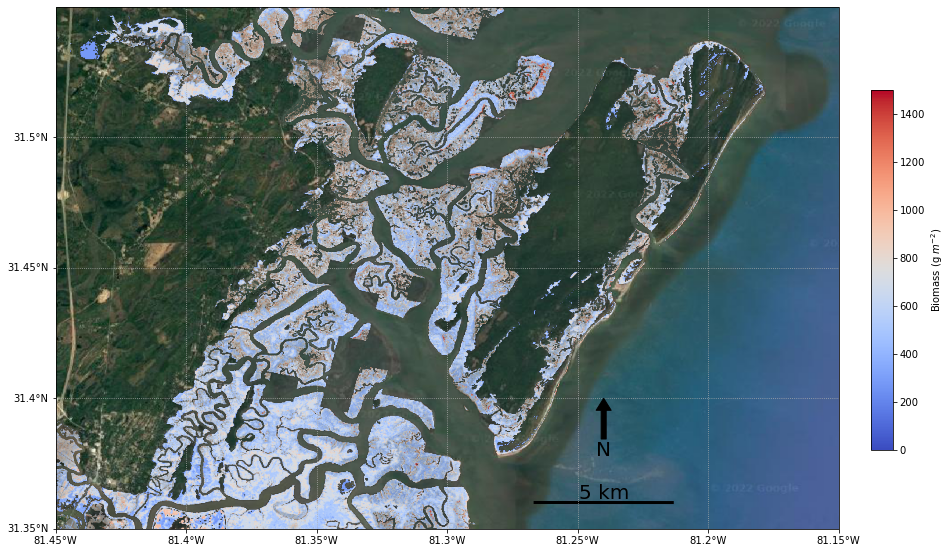

In [84]:
##Mapping in GA
from geemap import cartoee
import cartopy.io.img_tiles as cimgt

# geospatial region in format [E,S,W,N]
region = [-81.5, 31, -80.75, 32]  # define bounding box to request data
out_region = [180, -60, -180, 85]
zoom_region = [-81.15, 31.35, -81.45, 31.55]
flux_region = [-81.26, 31.42, -81.3, 31.45]

vis = {'min': 0, 'max': 1500}  # define vis parameters for image

cmap = "coolwarm"

fig = plt.figure(figsize=(15, 10))

basemap = cimgt.Stamen('terrain-background')

# use cartoee to get a map
ax = cartoee.get_map(classified_ga, region=zoom_region, vis_params=vis, cmap = cmap, basemap='SATELLITE', zoom_level=12)

# add a colorbar to the map using the visualization params we passed to the map
cartoee.add_colorbar(ax, vis, cmap = cmap, loc="right", label="Biomass (g $m^{-2}$)", orientation="vertical")

# add gridlines to the map at a specified interval
cartoee.add_gridlines(ax, interval=[0.05, 0.05], linestyle=":")

# add coastlines using the cartopy api - way off! check with zoomed out image
# ax.coastlines(color="red")

# add north arrow
cartoee.add_north_arrow(
    ax, text="N", xy=(0.7, 0.25), text_color="black", arrow_color="black", fontsize=20
)

# add scale bar
cartoee.add_scale_bar_lite(
    ax, length=5, xy=(0.7, 0.05), fontsize=20, color="black", unit="km"
)

##More info here: https://geemap.org/notebooks/50_cartoee_quickstart/#plotting-an-image
##And here: https://geemap.org/notebooks/66_cartoee_legend/
##https://geemap.org/notebooks/112_cartoee_basemap/#use-other-basemaps

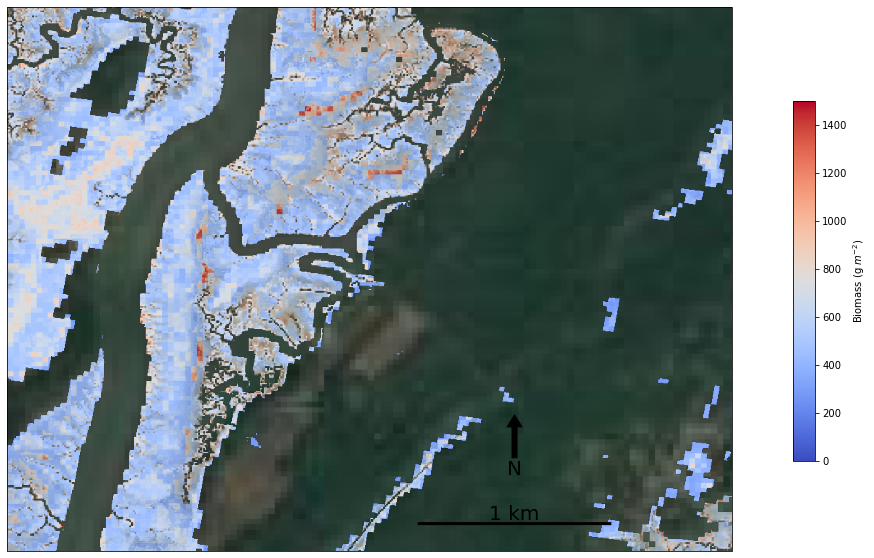

In [85]:
#Flux tower mapping
from geemap import cartoee
import cartopy.io.img_tiles as cimgt

# geospatial region in format [E,S,W,N]
region = [-81.5, 31, -80.75, 32]  # define bounding box to request data
out_region = [180, -60, -180, 85]
zoom_region = [-81.15, 31.35, -81.45, 31.55]
flux_region = [-81.26, 31.42, -81.3, 31.45]

vis = {'min': 0, 'max': 1500}  

cmap = "coolwarm"

fig = plt.figure(figsize=(15, 10))

basemap = cimgt.Stamen('terrain-background')

# use cartoee to get a map
ax = cartoee.get_map(classified_ga, region=flux_region, vis_params=vis, cmap = cmap, basemap='SATELLITE', zoom_level=12)

# add a colorbar to the map using the visualization params we passed to the map
cartoee.add_colorbar(ax, vis, cmap = cmap, loc="right", label="Biomass (g $m^{-2}$)", orientation="vertical")

# add gridlines to the map at a specified interval
cartoee.add_gridlines(ax, interval=[0.05, 0.05], linestyle=":")

# add coastlines using the cartopy api - way off! check with zoomed out image
# ax.coastlines(color="red")

# add north arrow
cartoee.add_north_arrow(
    ax, text="N", xy=(0.7, 0.25), text_color="black", arrow_color="black", fontsize=20
)

# add scale bar
cartoee.add_scale_bar_lite(
    ax, length=1, xy=(0.7, 0.05), fontsize=20, color="black", unit="km"
)


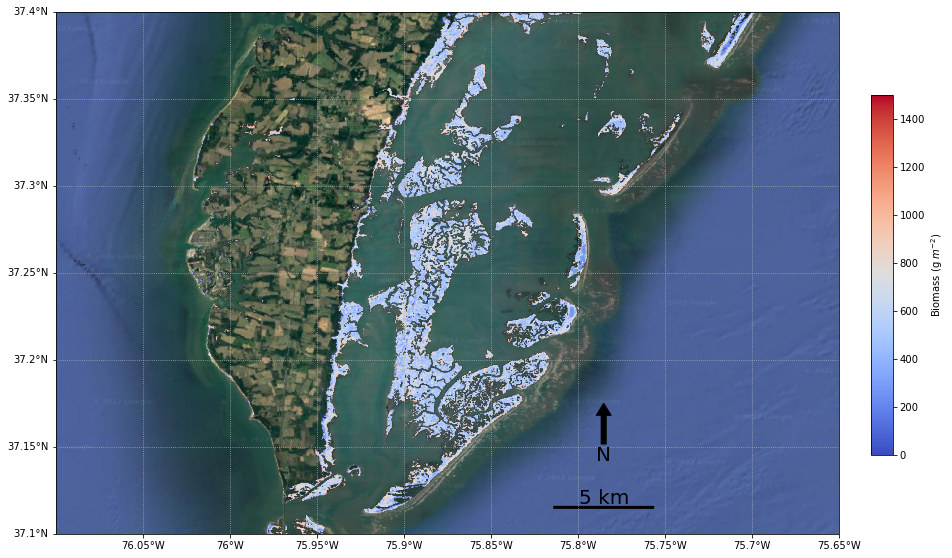

In [86]:
##Mapping in Virginia:
from geemap import cartoee

# geospatial region in format [E,S,W,N]
region = [-76.174, 37.1, -75.212, 37.818]
# define bounding box to request data
out_region = [180, -60, -180, 85]
zoom_region = [-75.65, 37.1, -76.1, 37.4]
ultrazoom_region = [-75.85, 37.15, -75.9, 37.2]
##Why are coordinates changing based on zoom level?? Projection issue?

# vis = {'min': 0, 'max': 1500, 'palette': ['1621A2', 'white', 'blue', 'cyan', 'green']}  # define vis parameters for image
vis = {'min': 0, 'max': 1500}  # define vis parameters for image

cmap = "coolwarm"

fig = plt.figure(figsize=(15, 10))

# use cartoee to get a map
ax = cartoee.get_map(classified_va, region=zoom_region, vis_params=vis, cmap = cmap, basemap='SATELLITE', zoom_level=12)

# add a colorbar to the map using the visualization params we passed to the map
cartoee.add_colorbar(ax, vis, cmap = cmap, loc="right", label="Biomass (g $m^{-2}$)", orientation="vertical")

# add gridlines to the map at a specified interval
cartoee.add_gridlines(ax, interval=[0.05, 0.05], linestyle=":")

# add coastlines using the cartopy api - way off! check with zoomed out image
# ax.coastlines(color="red")

# add north arrow
cartoee.add_north_arrow(
    ax, text="N", xy=(0.7, 0.25), text_color="black", arrow_color="black", fontsize=20
)

# add scale bar
cartoee.add_scale_bar_lite(
    ax, length=5, xy=(0.7, 0.05), fontsize=20, color="black", unit="km"
)

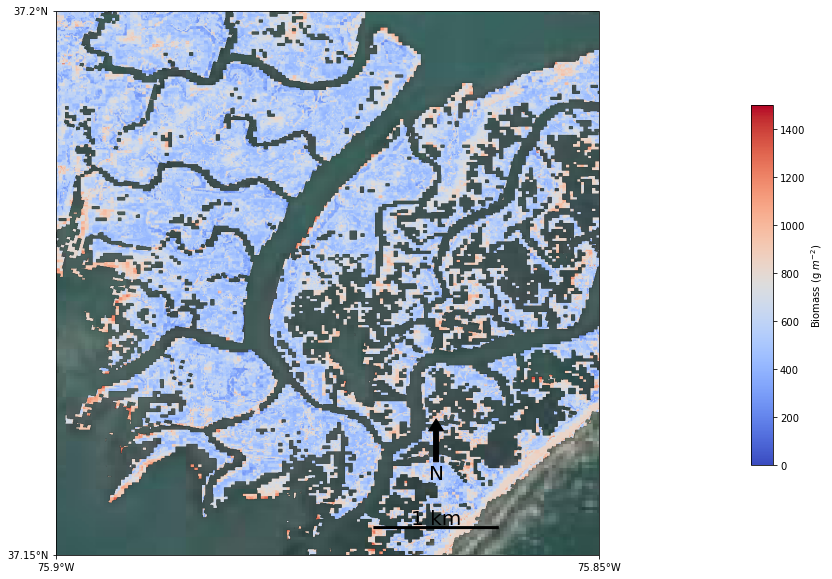

In [87]:
#VA zoom map
from geemap import cartoee

region = [-76.174, 37.1, -75.212, 37.818]
out_region = [180, -60, -180, 85]
zoom_region = [-75.65, 37.1, -76.1, 37.4]
ultrazoom_region = [-75.85, 37.15, -75.9, 37.2]

fig = plt.figure(figsize=(15, 10))

# use cartoee to get a map
ax = cartoee.get_map(classified_va, region=ultrazoom_region, vis_params=vis, cmap = cmap, basemap='SATELLITE', zoom_level=12)

# add a colorbar to the map using the visualization params we passed to the map
cartoee.add_colorbar(ax, vis, cmap = cmap, loc="right", label="Biomass (g $m^{-2}$)", orientation="vertical")

# add gridlines to the map at a specified interval
cartoee.add_gridlines(ax, interval=[0.05, 0.05], linestyle=":")

# add coastlines using the cartopy api - way off! check with zoomed out image
# ax.coastlines(color="red")

# add north arrow
cartoee.add_north_arrow(
    ax, text="N", xy=(0.7, 0.25), text_color="black", arrow_color="black", fontsize=20
)

# add scale bar
cartoee.add_scale_bar_lite(
    ax, length=1, xy=(0.7, 0.05), fontsize=20, color="black", unit="km"
)


In [ ]:
##Keep on keeping on